## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, RandomAdjustSharpness, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *

In [2]:
torch.manual_seed(27)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 32
batch_size = 128

transformation= Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1), 
                         RandomAdjustSharpness(2, p=1), 
                         ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [5]:
root = 'chest_xray/train'
# Convenience function to create dataset
train_data = create_dataset(root, transformation)
# Convenience function to create data loader
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1542, 1951, 2911, 3945, 2298, 4433, 1733, 1719, 1838]


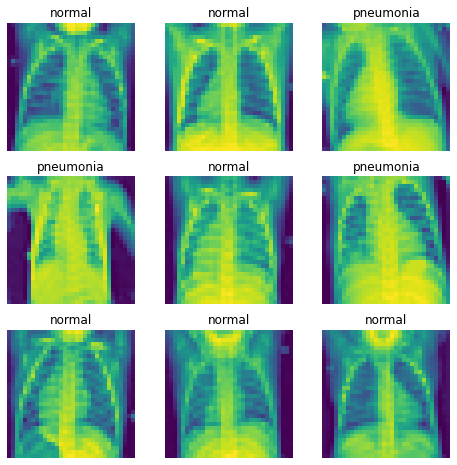

In [8]:
# Function to view randomly selected images
visualize_data(train_data)

[497, 414, 270, 579, 154, 484, 565, 3, 353]


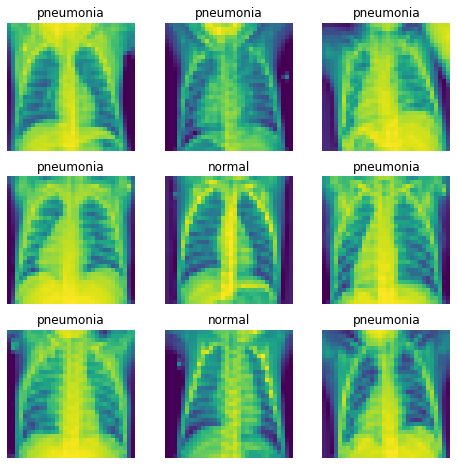

In [9]:
visualize_data(test_data)

## Initialize Model

In [10]:
# Convenience function to create optimizer
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [11]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# sharp sobel kernels (will have to update if kernel size increases)
# these will be the starting weights of the convolutional layers
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [1, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [12]:
model = DeepLearn(kernels=kernels, hidden=hidden,
                  kernel_size=kernel_size, window=window,
                  hidden_linear=hidden_linear).to(device)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=10816, out_features=512, bias=True)
  

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [15]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device=device, model=model,
                       train_loader=train_loader, val_loader=val_loader, 
                       optimizer=optimizer, epochs=20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.578125
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.7526041666666666
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.8046875
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.8134765625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.8266369047619048
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.8374399038461539
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.8422379032258065
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.8463541666666666
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.8519435975609756
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.8564877717391305
--- Epoch 1/20: Train loss: 0.3483, Train accuracy: 0.8569
--- Epoch 1/20: Val loss: 0.2834, Val accuracy: 0.8701
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.890625
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.890625
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.8955965909090909
Epoch 2/20, Batch number: 15, Cumulate

## Testing Model & Performance Curves

In [16]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=model, 
                                                          data_loader=test_loader, get_predictions=True)

Test loss: 0.3719, Test accuracy: 0.8684


Precision: 0.8723404255319149
Recall: 0.9601873536299765
F1 score: 0.9141583054626533


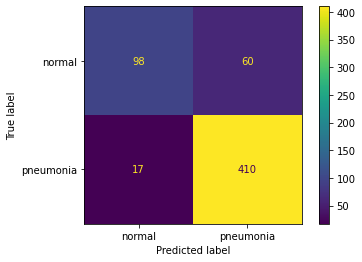

In [17]:
# Takes in lists of the true labels and model predictions,
# then computes the precision, recall, and f1 score
show_metrics(true_labels=true_labels, model_preds=model_preds)

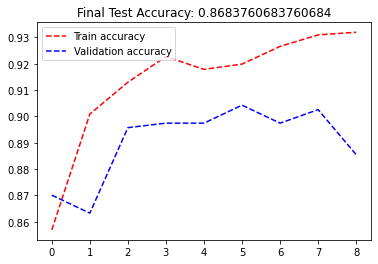

In [18]:
# See training curves
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
# Title is accuracy of model on test dataset
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

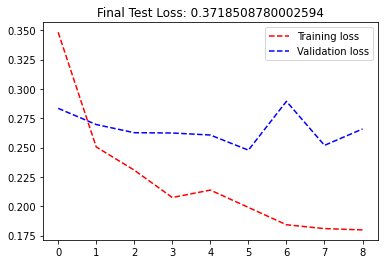

In [19]:
# See training curves
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
# Title is accuracy of model on test dataset
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
"""
get_pictures_test

A simplified version of the test function that returns four lists
used for image visualization and confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
autoencoder - autoencoder to use, if any (default is None)

Returns a list of correctly predicted images, a list of incorrectly predicted images, a list of true labels,
and a list of predictions made by the model each of length equal to the length of the data loader provided.

"""
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.8713080168776371
Recall: 0.9672131147540983
F1 score: 0.9167591564927859


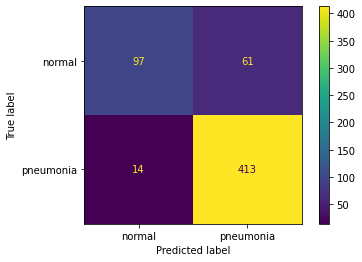

In [22]:
show_metrics(true_labels2, model_preds2)

[372, 242, 21, 155, 164, 449, 99, 61, 117, 303, 506, 185, 14, 482, 405, 405, 125, 368, 481, 255, 101, 327, 435, 138, 358]


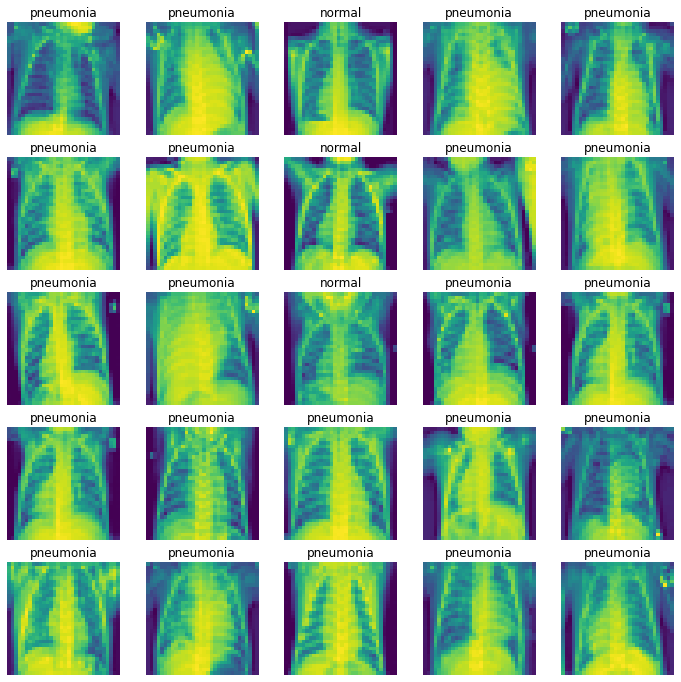

In [23]:
visualize_data(correct_list, (12,12), 5)

[41, 61, 49, 27, 37, 28, 40, 29, 36, 32, 51, 57, 10, 49, 43, 25, 29, 55, 18, 70, 29, 36, 20, 59, 41]


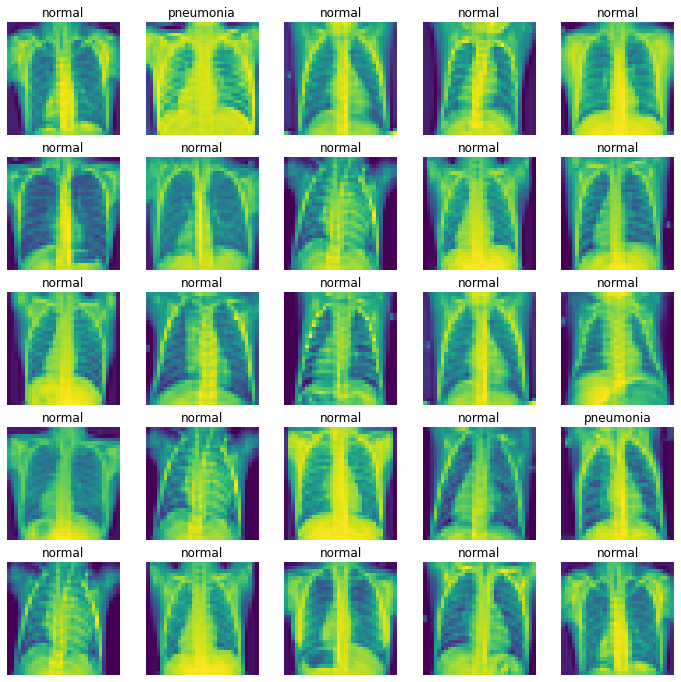

In [24]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepLearnCNN_4epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden,
                  kernel_size=kernel_size, window=window,
                  hidden_linear=hidden_linear).to(device)
model_test.load_state_dict(torch.load("./DeepLearn_1epochs")["model_state_dict"])